In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from lib.iux001 import fetch_data, aggregation_data,merging_data1
from lib.aux001 import calc_expression
from lib.cux001 import FactorEvaluate1

In [3]:
method = 'cicso0'
instruments = 'ims'
period = 15
task_id = '200037'
datasets = ['train', 'val']

In [4]:
total_data = fetch_data(method=method,
                        instruments=instruments,
                        task_id=task_id,
                        datasets=datasets)

./records/cicso0/ims/level2/train_data.feather
./records/cicso0/ims/level2/val_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/returns/val_returns.feather


In [5]:
total_data.head()

,trade_time,symbol,open,high,low,close,volume,money,twap,pct_change,...,realized_volatility,code,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,nxt1_ret_5h,nxt1_ret_10h,nxt1_ret_15h,time_weight,equal_weight
0,2022-07-25 09:31:00,IM2208,6971.8,6994.8,6964.4,6973.8,602,840545880.0,6981.585000,0.000287,...,0.002546,IM,0.000498,0.000926,0.002696,0.003720,0.001397,0.001650,0.001007,0.001374
1,2022-07-25 09:32:00,IM2208,6973.8,6995.2,6969.6,6982.8,428,597671840.0,6982.126050,0.001291,...,0.001839,IM,0.000428,0.002198,0.002777,0.002744,0.001638,-0.000076,0.001409,0.001801
2,2022-07-25 09:33:00,IM2208,6982.8,6989.8,6981.6,6989.8,280,391195160.0,6985.326496,0.001002,...,0.001727,IM,0.001770,0.002349,0.002794,0.003311,0.000932,-0.000296,0.002134,0.002304
3,2022-07-25 09:34:00,IM2208,6989.6,6993.0,6982.6,6993.0,319,445873560.0,6988.716949,0.000486,...,0.001665,IM,0.000579,0.001023,0.000546,0.001704,-0.000473,-0.003404,0.000721,0.000716
4,2022-07-25 09:35:00,IM2208,6993.6,7009.0,6991.8,7002.2,284,397659840.0,6999.337288,0.001230,...,0.001700,IM,0.000445,-0.000033,0.000962,0.000182,-0.000986,-0.005230,0.000372,0.000458


In [6]:
#total_data.set_index('trade_time').loc['2024-12-04 10:43:00':]

In [7]:
total_data.filter(regex="^nxt1").columns.to_list()
nxt1_columns = total_data.filter(regex="^nxt1").columns.to_list()
basic_columns = [
        'close', 'high', 'low', 'open', 'volume'
        #, 'value', 'openint'
    ]

regex_pattern = r'^[^_]+_(5|10|15)_.*'
not_columns = total_data.columns[total_data.columns.str.contains(
        regex_pattern)]

factor_columns = [
        col for col in total_data.columns
        if col not in ['trade_time', 'code'] + nxt1_columns + basic_columns +
        not_columns.tolist()
    ]#[0:100]

In [8]:
#total_data

In [9]:
total_data = total_data[['trade_time', 'code'] + factor_columns + basic_columns + ["nxt1_ret_{}h".format(period)]]
total_data.head()

,trade_time,code,symbol,money,twap,pct_change,pct_change_close,pct_change_set,tick_in,tick_out,...,ask_bid_press,realized_volatility,time_weight,equal_weight,close,high,low,open,volume,nxt1_ret_15h
0,2022-07-25 09:31:00,IM,IM2208,840545880.0,6981.585000,0.000287,0.002472,0.005711,55,65.0,...,0.191198,0.002546,0.001007,0.001374,6973.8,6994.8,6964.4,6971.8,602,0.001650
1,2022-07-25 09:32:00,IM,IM2208,597671840.0,6982.126050,0.001291,0.003766,0.007009,59,60.0,...,0.243969,0.001839,0.001409,0.001801,6982.8,6995.2,6969.6,6973.8,428,-0.000076
2,2022-07-25 09:33:00,IM,IM2208,391195160.0,6985.326496,0.001002,0.004772,0.008018,54,63.0,...,0.337424,0.001727,0.002134,0.002304,6989.8,6989.8,6981.6,6982.8,280,-0.000296
3,2022-07-25 09:34:00,IM,IM2208,445873560.0,6988.716949,0.000486,0.005232,0.008480,55,63.0,...,-0.099565,0.001665,0.000721,0.000716,6993.0,6993.0,6982.6,6989.6,319,-0.003404
4,2022-07-25 09:35:00,IM,IM2208,397659840.0,6999.337288,0.001230,0.006555,0.009806,62,56.0,...,0.132744,0.001700,0.000372,0.000458,7002.2,7009.0,6991.8,6993.6,284,-0.005230


In [10]:
expression = "MA(90,'smart_tick_in_pct')"

In [11]:
%%time
factor_data = calc_expression(expression=expression,
                              total_data=total_data.set_index('trade_time'))

CPU times: user 3.6 s, sys: 397 ms, total: 4 s
Wall time: 4 s


In [12]:
factor_data.tail()

,trade_time,transformed,code
137584,2024-12-04 10:38:00,0.371588,IM
137585,2024-12-04 10:39:00,0.375001,IM
137586,2024-12-04 10:40:00,0.379276,IM
137587,2024-12-04 10:41:00,0.383326,IM
137588,2024-12-04 10:42:00,0.386902,IM


In [13]:
#factor_data.merge(total_data[['trade_time','code','nxt1_ret_15h']], on=['trade_time','code'])

In [14]:
dt = merging_data1(factor_data=factor_data,
                      returns_data=total_data,
                      period=period)

In [15]:
dt.tail()

,trade_time,transformed,code,nxt1_ret_15h
137584,2024-12-04 10:38:00,0.371588,IM,-0.006239
137585,2024-12-04 10:39:00,0.375001,IM,-0.005565
137586,2024-12-04 10:40:00,0.379276,IM,-0.006340
137587,2024-12-04 10:41:00,0.383326,IM,-0.004891
137588,2024-12-04 10:42:00,0.386902,IM,-0.003720


In [20]:
evaluate1 = FactorEvaluate1(factor_data=dt,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=15,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression=expression,
                                resampling_win=period)

In [21]:
stats_dt = evaluate1.run()

In [22]:
stats_dt

{'total_ret': 0.4791782180769115,
 'avg_ret': 4.480589375949886e-05,
 'max_dd': -0.09396319378106421,
 'calmar': 5.099637409020011,
 'sharpe1': 0.021717997770189665,
 'sharpe2': 1.1311766473867024,
 'turnover': 0.4011665347906169,
 'win_rate': 0.5139555167902311,
 'profit_ratio': 1.0830278673668543,
 'ic_mean': 0.14716425202931602,
 'ic_std': 0.24597046406014203,
 'ic_ir': 0.5983005016136125,
 'factor_autocorr': 0.9650319812431418,
 'ret_autocorr': -0.050231916624552016}

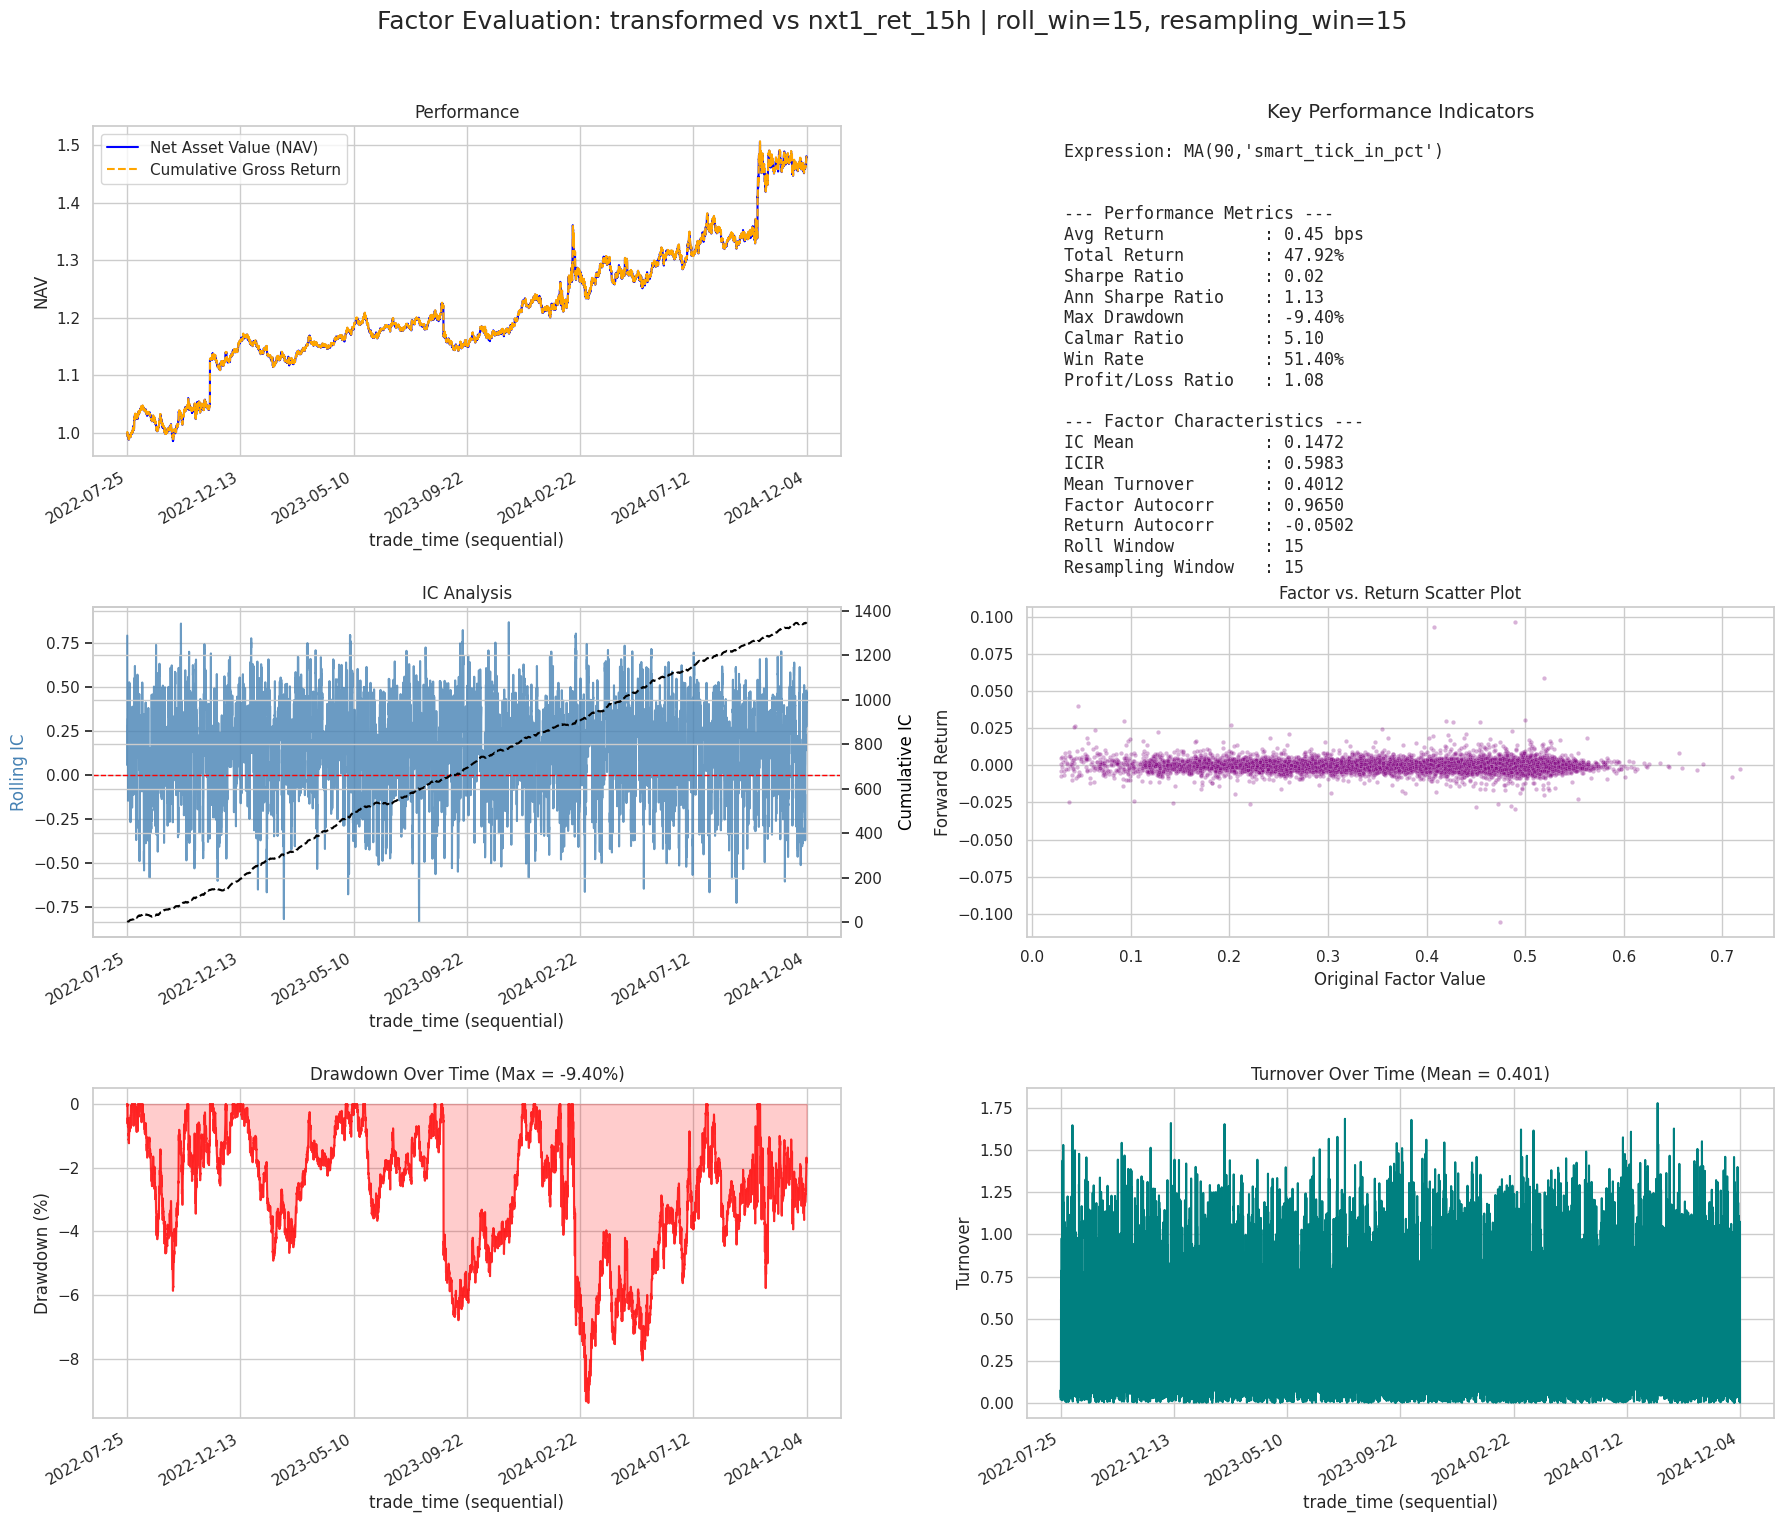

In [23]:
evaluate1.plot_results()

In [18]:
evaluate1.save_results(base_output_dir='./')

Saving results to: ./20251102_074903
Performance summary saved to: ./20251102_074903/performance_summary.txt
Saving time series data as separate files...
 -> Saved ./20251102_074903/nav.csv
 -> Saved ./20251102_074903/ic.csv
 -> Saved ./20251102_074903/turnover.csv
Evaluation plot saved to: ./20251102_074903/evaluation_plot.png
Evaluation plot also saved to: ./plot/20251102_074903.png
